In [1]:
import pandas as pd
import seaborn as sns
import pickle
import numpy as np

sns.set_style("whitegrid")

In [3]:
with open("../data/bert_tokenized/bert_train_data.pkl", "rb") as f:
    train_dev = pickle.load(f)

with open("../data/bert_tokenized/bert_test_data.pkl","rb") as f:
    test = pickle.load(f)

In [2]:
lr= [1e-06, 1.0800000000000002e-05, 2.0600000000000003e-05,3.0400000000000004e-05, 4.02e-05,5e-05]
hidden= [True, False]

# dims =  lr x hidden x 3 runs x (train vs val)
results = np.zeros((len(lr), len(hidden),3,2))


In [6]:
for i, l in enumerate(lr):
    for j, h in enumerate(hidden):
        results[i,j,:,:] = np.genfromtxt(f"../results/{l}_{h}.csv", delimiter=",")
        

In [13]:
with open("../results/results.pkl", "wb") as f:
    pickle.dump(results,f)

In [4]:
results_rows = []

# dims =  lr x hidden x 3 runs x (train vs val)
for i, l in enumerate(lr):
    for j, h in enumerate(hidden):
        results = np.genfromtxt(f"../results/{l}_{h}.csv", delimiter=",")
        results_rows.extend([[l, h, results[r][0], results[r][1]] for r in range(3)])


In [5]:
results_df = pd.DataFrame(data=results_rows, columns=["lr", "hidden", "train_acc", "val_acc"])
results_df.head()

,lr,hidden,train_acc,val_acc
0,0.000001,True,71.263654,70.444775
1,0.000001,True,71.555362,70.171958
2,0.000001,True,70.301639,69.506448
3,0.000001,False,71.325720,70.027282
4,0.000001,False,70.841609,70.081019


In [6]:
mean_per_param_combination = results_df.groupby(['lr', 'hidden']).mean().sort_values(by=["val_acc","train_acc"],ascending=False)
mean_per_param_combination.head()

,,train_acc,val_acc
lr,hidden,,
0.000030,False,96.012289,74.805721
0.000011,False,86.340409,74.564594
0.000021,False,93.024868,74.563216
0.000050,False,97.954940,74.502590
0.000021,True,91.787694,74.473655


In [7]:
mean_per_lr = results_df.groupby(['lr']).mean().sort_values(by=["val_acc","train_acc"], ascending=False)
mean_per_lr.head()

,hidden,train_acc,val_acc
lr,,,
0.000021,0.5,92.406281,74.518436
0.000011,0.5,85.890951,74.468144
0.000030,0.5,95.272157,74.466077
0.000050,0.5,97.403074,74.448165
0.000040,0.5,96.570362,74.335869


In [8]:
mean_per_hidden = results_df.groupby(['hidden'])[['train_acc','val_acc']].mean().sort_values(by=["val_acc","train_acc"], ascending=False)
mean_per_hidden.head()

,train_acc,val_acc
hidden,,
False,90.328292,73.834325
True,89.258696,73.616852


<h1> heatmap of params, compare train/val acc? </h1>

In [31]:
mean_per_param_combination.reset_index().lr.unique()

array([3.04e-05, 1.08e-05, 2.06e-05, 5.00e-05, 4.02e-05, 1.00e-06])

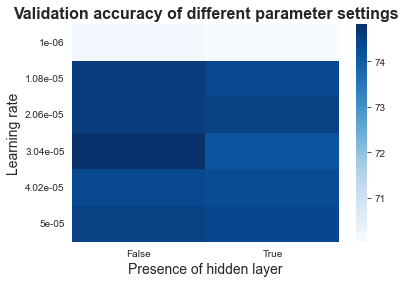

In [35]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots()
sns.heatmap(mean_per_param_combination.reset_index()[["lr", "hidden","val_acc"]].pivot("lr", "hidden","val_acc"),cmap = "Blues",ax=ax)
ax.set_ylabel("Learning rate",size=14)
ax.set_yticklabels([1.00e-06,1.08e-05,2.06e-05,3.04e-05, 4.02e-05, 5.00e-05])
ax.set_xlabel("Presence of hidden layer",size=14)
ax.set_title("Validation accuracy of different parameter settings", weight="bold", size=16)
plt.savefig("../plots/param_heatmap.pdf")
plt.show()

<h1> train & eval best model 3 x on train_val data </h1>

<h1> precision, recall, f1 </h1>